In [1]:
from importlib import reload
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
import numpy as np
import pickle
import itertools
import multiprocessing as mp
from datetime import date, timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
import randomforestanalysis as RFA; reload(RFA)
from matplotlib import rc

In [2]:
fs = 20

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : fs
       }

rc('font', **font)

In [3]:
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 1000)
pd.set_option('max_colwidth', 1000)

In [4]:
# enddates = pd.read_csv('enddates.csv',index_col=["Country"],parse_dates=["enddate"])
# enddates['enddate'] = enddates['enddate'].apply(lambda x: x.date())

# enddates_new = pd.DataFrame({'enddate':pd.Series({'Poland':date(2020,6,19),'Senegal':date(2020,7,15),'Ghana':date(2020,7,6)})})
# enddates = enddates.append(enddates_new)
# del enddates_new

In [5]:
datasource = "CCCSL"

In [6]:
if datasource == "CCCSL":
    datapath = '../merged_data/COVID19_data_cumulative_PAPER_VERSION.csv'
    file_ending = ''

else:
    file_ending = '_'+datasource
    datapath = '../merged_data/other_sources/COVID19_data_cumulative_PAPER_VERSION'+file_ending+'.csv'

In [7]:
#reload(RFA)
rfa = RFA.RandomForestAnalysis(timeshift=[s for s in range(0,21)],
                               n_splits=10,
                               enddate = date(2020,4,30),
                               minsamples_leaf=[1],
                               max_tree_depth = [d for d in range(1,16)],
                               max_features = [k/100 for k in range(1,101)],
                               n_estimators=500,
                               outcome_name = "R",
                               data_path = '../merged_data/COVID19_data_cumulative_PAPER_VERSION.csv'
                               )

In [9]:
rfa._measurenames = list(rfa.data.columns[10:-5],)
rfa.get_predictors()
rfa.get_outcome()

In [43]:
# rfa.crossvalidate(n_processes=30)

In [9]:
rfa.cv_results = pd.read_csv('cv_results_new_CCCSL.csv',index_col=0)

In [7]:
# reload(RFA)
# pickle.dump(rfa,open("RF_analysis"+file_ending+".pkl", "wb" ) )

rfa = pickle.load(open("RF_analysis"+file_ending+".pkl","rb"))

###### Determine best value for hyperparameter m, depending on time shift s

In [8]:
countries = pd.read_csv('countries.csv',sep=';')

In [9]:
rfa.get_performance()

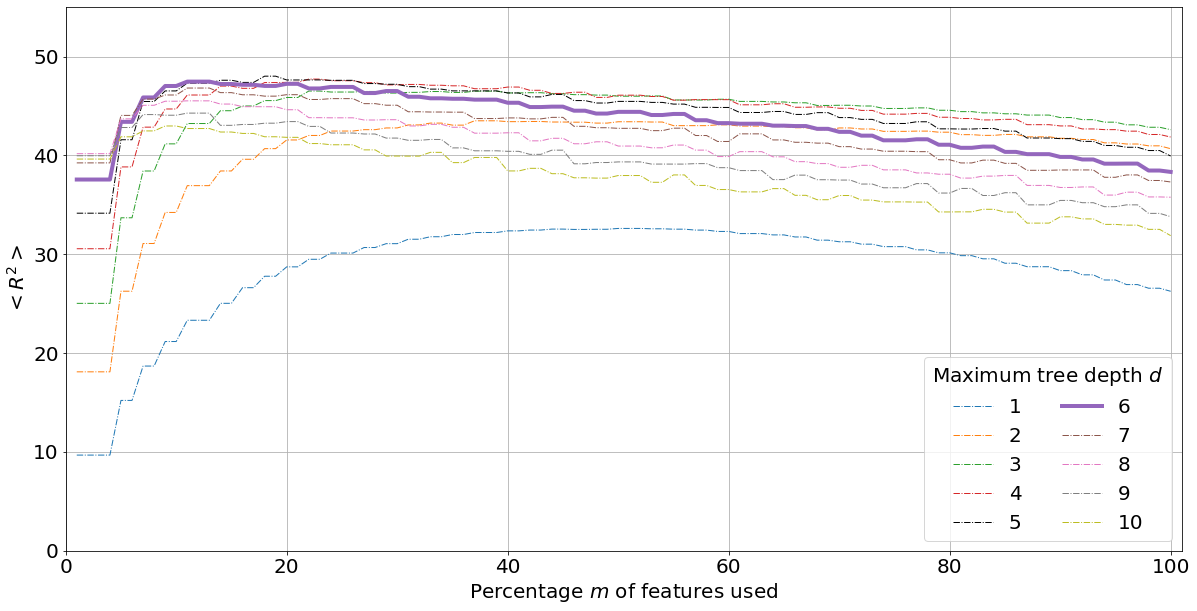

In [13]:
plt.figure(figsize=(20,10))
ax = plt.gca()

for d in range(1,11):
    if d!=5:
        rfa.performance[[("R2_test","mean")]].loc[(10,1,d,slice(None)),].plot(table=False,xlim=(0,100),ylim=(0,0.6),ax=ax,legend=False,use_index=False,linestyle='-' if d==6 else 'dashdot',label=d,linewidth=4 if d==6 else 1)#,color='red' if d==6 else 'k')
    if d==5:
        rfa.performance[[("R2_test","mean")]].loc[(10,1,d,slice(None)),].plot(table=False,xlim=(0,100),ylim=(0,0.6),ax=ax,legend=False,use_index=False,linestyle='-' if d==6 else 'dashdot',label=d,linewidth=4 if d==6 else 1,color='k')
    
plt.xticks(np.arange(-1,100,20),np.arange(0,101,20))
plt.yticks(np.arange(0,0.6,0.1),np.arange(0,60,10))
plt.axis(xmin=-1,xmax=100,ymin=0,ymax=0.55)
plt.legend([d for d in range(1,16)],title='Maximum tree depth $d$',ncol=2)
plt.grid(axis='both')
ax.set_xlabel("Percentage $m$ of features used")
ax.set_ylabel('$<R^2>$')
plt.savefig('crossvalidation_RF'+file_ending+'..pdf',bbox_inches='tight',creator="NHaug")

plt.show()

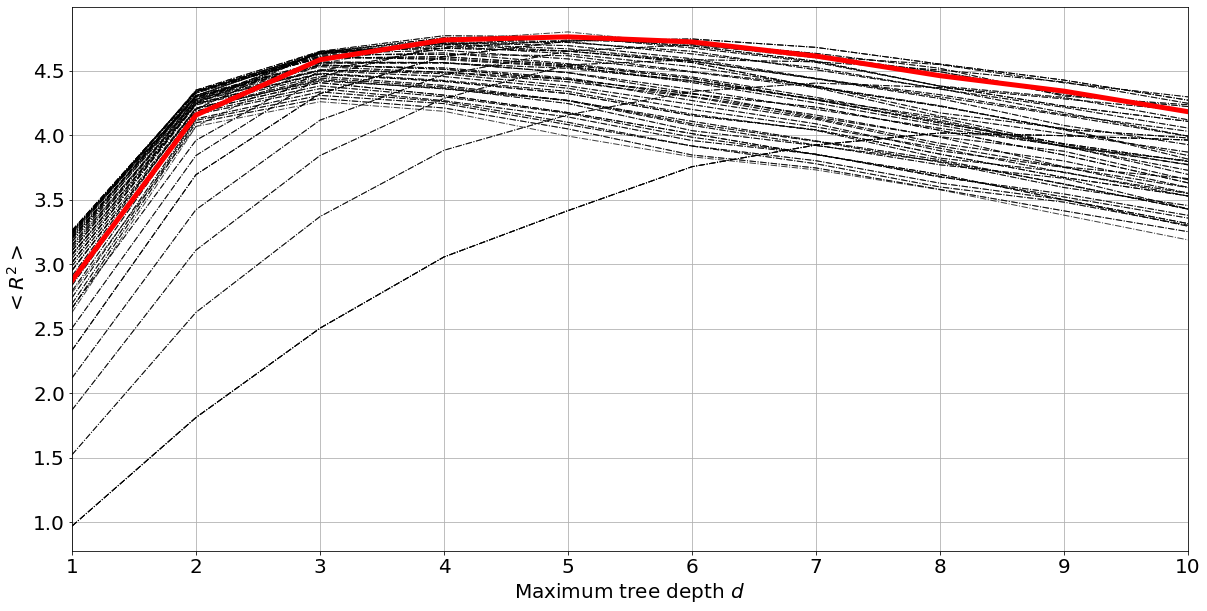

In [14]:
# for d in range(1,15):

plt.figure(figsize=(20,10))

ax = plt.gca()

for m in rfa.performance.index.get_level_values(3).unique():
    
    if m != .18: 
    
        rfa.performance[[("R2_test","sum")]].loc[(10,1,slice(1,16),m),].plot(ax=ax,legend=False,use_index=False,color='k',linewidth=1,alpha=.75,linestyle='dashdot')

    
rfa.performance[[("R2_test","sum")]].loc[(10,1,slice(1,16),.21),].plot(ax=ax,legend=False,use_index=False,color='red',linewidth=5)

plt.xticks(np.arange(-1,10,1),np.arange(0,11,1))
# plt.yticks(np.arange(0,0.6,0.1),np.arange(0,60,10))
        
plt.axis(xmin=0,xmax=9)#,ymin=0,ymax=0.55)
# plt.legend([d for d in range(1,16)],title='Maximum tree depth $d$',ncol=2)
plt.grid(axis='both')
ax.set_xlabel("Maximum tree depth $d$")
ax.set_ylabel('$<R^2>$')
plt.savefig('crossvalidation_RF_2'+file_ending+'.pdf',bbox_inches='tight',creator="NHaug")    

plt.show()

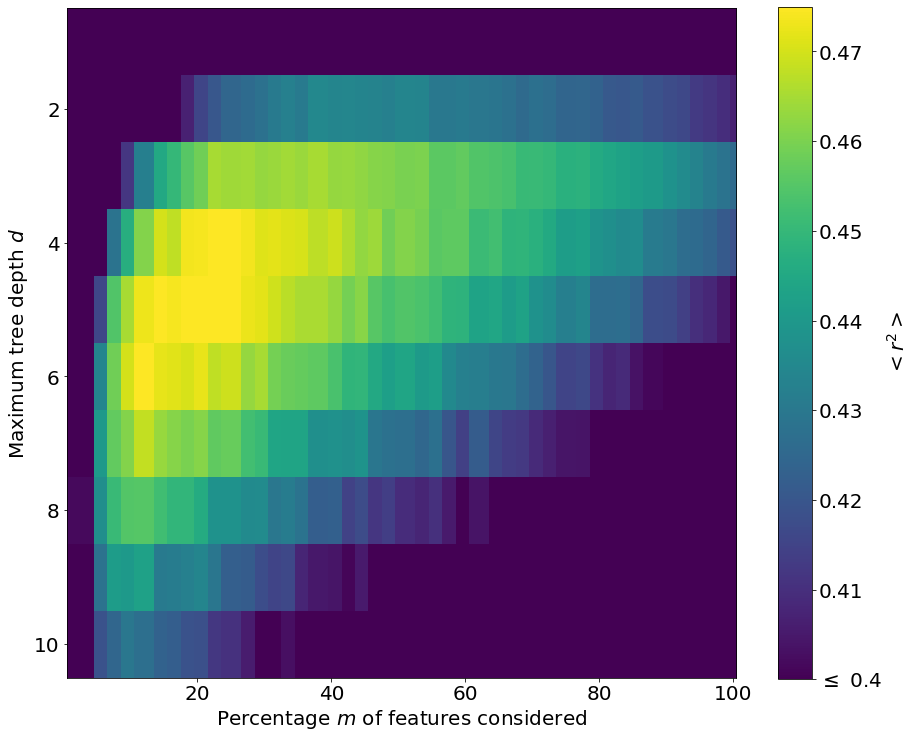

In [12]:
fig = plt.figure(figsize=(15,15))
ax = plt.gca()
cax = plt.imshow(rfa.performance.loc[(10,1,slice(None),slice(None)),[("R2_test","mean")]].droplevel(['timeshift','min_samples_leaf']).unstack(level=1).values[:10,:],aspect=10,vmin=0.40,vmax=0.475)
cbar = fig.colorbar(cax, orientation='vertical',shrink=.825,label="$<r^2>$")
cbar.ax.set_yticklabels(["$\leq$ 0.4","0.41","0.42","0.43","0.44","0.45","0.46","0.47"])
plt.xticks([19,39,59,79,99],[20,40,60,80,100])
plt.yticks(np.arange(1,11,2),np.arange(2,11,2))
ax.set_ylabel('Maximum tree depth $d$')
ax.set_xlabel('Percentage $m$ of features considered')
plt.savefig('crossvalidation_RF_heatmap'+file_ending+'.pdf',bbox_inches="tight")
plt.show()

In [10]:
# rfa.plot_country_fits(time_shift=10,min_samples_leaf=1,max_depth=5,max_features=.21,countries=["Germany","Japan","Brazil","Mexico","Thailand","Austria","France","Italy","Spain","United Kingdom","Sweden","Switzerland"])

In [12]:
countries = pd.read_csv('countries.csv',header=0,sep=';',index_col="Country",usecols=["Country","Europe+Africa","Asia+Oceania","Americas"]).fillna(False).replace(1,True)

countrylists = dict()

countrylists["Americas"] = list(countries.loc[countries["Americas"]==True].index)
countrylists["Asia"]     = list(countries.loc[countries["Asia+Oceania"]==True].index)
countrylists["Europe"]   = list(countries.loc[countries["Europe+Africa"]==True].index)
countrylists["None"]     = []

permutation_importances = dict()

In [ ]:
t = rfa._timeshift

n_processes = 21
  
def fun(s,rfa,dropcountries):

    p = rfa.get_optimal_parameters("R2_test",s)
    d = p[1]
    m = p[2]
    
    return rfa.get_permutation_importance(time_shift=s,min_samples_leaf=1,max_depth=d,max_features=m,n_splits=10,n_repeats=200,drop_countries=dropcountries)

for continent in ['Europe','Asia','Americas']:
    
    print(continent)

    args = list(map(lambda s: (s,rfa,countrylists[continent]),t))

    pool = mp.Pool(processes=n_processes)

    newres = pool.starmap(fun,args)

    pool.close()
    pool.join()

    permutation_importances[continent] = pd.concat(newres)

    rfa.permutation_importances = permutation_importances
    
    pickle.dump(rfa,open("RF_analysis"+file_ending+".pkl", "wb" ) )

Europe
Asia
Americas


In [20]:
pickle.dump(rfa,open("RF_analysis"+file_ending+".pkl", "wb" ))

In [29]:
# rfa.permutation_importances['Asia'].to_csv('pi_Asia.csv',sep=';')

In [15]:
permutation_importances['Asia'] = pd.read_csv('pi_Asia.csv',sep=';',index_col=0)

In [17]:
permutation_importances['Americas'] = pd.read_csv('pi_Americas.csv',sep=';',index_col=0)

In [18]:
permutation_importances['Europe'] = pd.read_csv('pi_Europe.csv',sep=';',index_col=0)

In [19]:
permutation_importances['None'] = pd.read_csv('pi_None.csv',sep=';',index_col=0)

In [30]:
rfa.permutation_importances['Americas'].to_csv('pi_Americas.csv',sep=';')

In [31]:
rfa.permutation_importances['Europe'].to_csv('pi_Europe.csv',sep=';')

In [22]:
# reload(RFA)
RFA.feature_ranking(rfa.permutation_importances["Americas"])[['Measure','mean_Delta',"CI"]]

,Measure,mean_Delta,CI
Rank,,,
18,ActivateCaseNotification,0.003881,0.001583
34,ActivateOrEstablishEmergencyResponse,0.001056,0.001239
22,ActivelyCommunicateWithHealthcareProfessionals1,0.003233,0.001640
10,ActivelyCommunicateWithManagers1,0.006961,0.002224
44,AdaptProceduresForPatientManagement,-0.000975,0.001217
23,AirportHealthCheck,0.003026,0.001466
43,AirportRestriction,-0.000662,0.001619
16,BorderHealthCheck,0.004644,0.001473
1,BorderRestriction,0.048591,0.002944
